# Importações e normalização

In [ ]:
# Importing the necessary models
import glob
import os
import numpy as np
import pandas as pan
import matplotlib.pyplot as plotter
import seaborn as sns
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import exposure, img_as_float, img_as_ubyte
from sklearn.metrics import confusion_matrix
from google.colab import files

!pip install visualkeras

import visualkeras
from collections import defaultdict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
# Fazer esse processo apenas uma vez, depois comentar
# # Instala o kaggle
!pip install kaggle

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download -d "thomasdubail/brain-tumors-256x256"

 98% 58.0M/59.4M [00:00<00:00, 87.1MB/s]
100% 59.4M/59.4M [00:00<00:00, 73.1MB/s]


In [ ]:
# Fazer esse processo apenas uma vez, depois comentar
# Cria um diretório (Dataset) e descompacta os dados dentro
!mkdir Dataset
!cp /content/brain-tumors-256x256.zip /content/Dataset/brain-tumors-256x256.zip
!unzip -q /content/Dataset/brain-tumors-256x256.zip -d /content/Dataset
!rm /content/brain-tumors-256x256.zip

In [ ]:
dir = "Dataset/Data"
files = [i for i in glob.glob(dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pan.DataFrame(data, columns = ["Image", "Label"])

dataframe.head()

,Image,Label
0,Dataset/Data/meningioma_tumor/M_606.jpg,meningioma_tumor
1,Dataset/Data/pituitary_tumor/P_844.jpg,pituitary_tumor
2,Dataset/Data/meningioma_tumor/M_362.jpg,meningioma_tumor
3,Dataset/Data/pituitary_tumor/P_266.jpg,pituitary_tumor
4,Dataset/Data/glioma_tumor/G_39.jpg,glioma_tumor


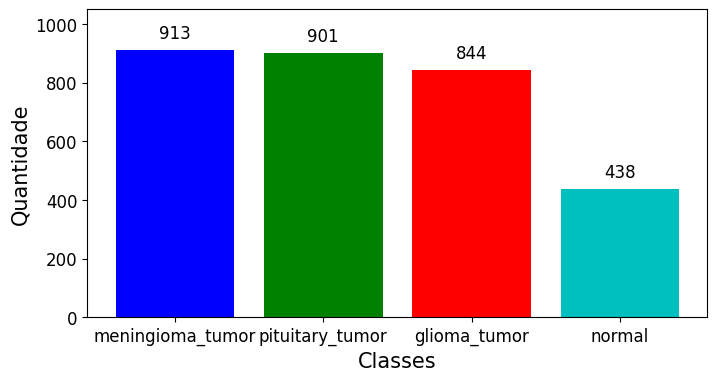

In [ ]:
# Quantidade de classes
classes = dataframe['Label'].unique()

# Quantidade de imagens em cada classe
qnt_imagens_por_classe = dataframe['Label'].value_counts()

# Criar figura e eixo
fig, ax = plt.subplots()

# Plotar gráfico de barras
barras = ax.bar(classes, qnt_imagens_por_classe, color=(('b','g','r','c')))
# Adicionar rótulos de dados nas barras
for bar, label in zip(barras, qnt_imagens_por_classe):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height+25, label,
            ha='center', va='bottom', fontsize=12)

# Limitar o eixo y
ax.set_ylim(00, 1050)

# Adicionar rótulos e título
ax.set_xlabel('Classes', fontsize=15)
ax.set_ylabel('Quantidade', fontsize=15)

# Definir tamanho da figura
fig.set_size_inches(8, 4)

# Modificar o tamanho da fonte nos rótulos dos ticks do eixo x e y
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Exibir o gráfico
plt.show()

meningioma_tumor


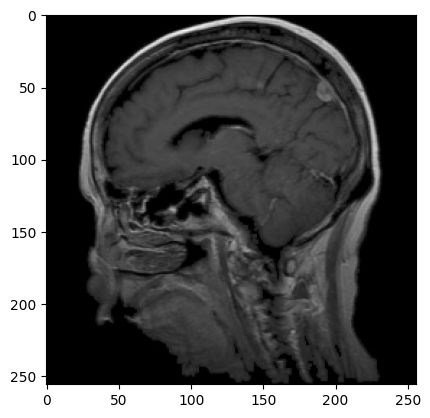

In [ ]:
print(dataframe["Label"].iloc[0])
array = plotter.imread(dataframe["Image"].iloc[0])
plotter.imshow(array)

In [ ]:
mappings = {k: i for i, k in enumerate(dataframe["Label"].unique())}

# Preprocessamento
features = dataframe["Image"].values
label = dataframe["Label"].map(mappings).values

# Divisão dos dados em 80/20
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size = 0.2)

train_dataset = tf.data.Dataset.from_tensor_slices((feature_train, label_train))
test_dataset = tf.data.Dataset.from_tensor_slices((feature_test, label_test))

def preprocessor(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_image(image, channels = 1, expand_animations = False) # Decodifica a imagem
  image = tf.image.resize(image, (256, 256)) # Redimenciona a imangem para o formato 256x256 pixels
  return image/255, tf.one_hot(label, depth = 4) # Normaliza a imagem

train_dataset = train_dataset.map(preprocessor)
test_dataset = test_dataset.map(preprocessor)


train_dataset_loader = train_dataset.batch(128).shuffle(64).prefetch(64)
test_dataset_loader = test_dataset.batch(128).shuffle(128).prefetch(128)

# Sigmoid 32

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation = 'sigmoid'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

Epoch 1/50


In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

# Sigmoid 64

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# Sigmoid 128

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'sigmoid'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# Tangente Hiperbolica 32

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# Tangente Hiperbolica 64

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = 'tanh'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# Tangente Hiperbolica 128

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'tanh'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# Relu 32

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# Relu 64

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# Relu 128

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

# 3 Camadas de convolução 32 x 64 x 128 (3 x 3) - MaxPoll2D (2 x 2)

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, legend=True, draw_volume=False, scale_xy=1, scale_z=2, max_z=30, color_map=color_map)

# 5 Camadas de convolução - 32 x 64 x 128 x 128 x 64 (3 x 3) - MaxPool2D (2 x 2)

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 40, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, legend=True, draw_volume=False, scale_xy=1, scale_z=2, max_z=30, color_map=color_map)

# 4 Camadas de convolução - 32 x 64 x 128 x 256 (4 x 4) - MaxPool (3 x 3)

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 50, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)

model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Conv2D(64, (4, 4), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Conv2D(128, (4, 4), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Conv2D(256, (4, 4), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, legend=True, draw_volume=False, scale_xy=1, scale_z=2, max_z=30, color_map=color_map)

# 4 Camadas de convolução - 32 x 64 x 128 x 256 (3 x 3) - relu 256 (3 x )

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 40, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPool2D((3, 3)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, legend=True, draw_volume=False, scale_xy=1, scale_z=2, max_z=30, color_map=color_map)

# 4 Camadas de convolução - 32 x 64 x 128 x 256 (3 x 3) - relu 256 (3 x )

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 40, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((3, 3)))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((3, 3)))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((3, 3)))

model.add(Dropout(0.2))
model.add(BatchNormalization(momentum=0.8))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPool2D((1, 1)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, legend=True, draw_volume=False, scale_xy=1, scale_z=2, max_z=30, color_map=color_map)

# 5 Camadas de convolução - 64 x 128 x 128 x 128 x 128 (2 x 2)

In [ ]:
# Uso de callback para reduzir o overfitting
callback_one = EarlyStopping(patience = 40, restore_best_weights = True)
callback_two = ReduceLROnPlateau(patience = 40)

model = Sequential()
model.add(Conv2D(64, (2, 2), input_shape = (256, 256, 1), activation = 'relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (2, 2), activation = 'relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (2, 2), activation = 'relu'))
model.add(MaxPool2D((2, 2)))

model.add(Dropout(0.2))
model.add(BatchNormalization(momentum=0.8))

model.add(Conv2D(128, (2, 2), activation = 'relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (2, 2), activation = 'relu'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization(momentum=0.8))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = "softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

history = model.fit(
    train_dataset_loader,
    validation_data = test_dataset_loader,
    callbacks=[callback_one, callback_one],
    batch_size = None,
    epochs=50)

In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
plt.style.use('default')
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento','Validação'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de perda')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['Treinamento','Validação'], loc='upper right')

In [ ]:
# Fazer previsões usando o conjunto de teste
y_true = np.concatenate([y.numpy() for _, y in test_dataset_loader], axis=0)
y_pred_probs = model.predict(test_dataset_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

# Converter os rótulos one-hot de volta para classes numéricas
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataframe["Label"].unique(),
            yticklabels=dataframe["Label"].unique())
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation = 90)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, legend=True, draw_volume=False, scale_xy=1, scale_z=2, max_z=30, color_map=color_map)

# Testes

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, legend=True, draw_volume=False, scale_xy=1, scale_z=2, max_z=30, color_map=color_map)

# Fim